In [58]:
import sys
sys.path.append('..')
from tsai.utils import *
from tsai.basics import *
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)
from swdf.utils import generate_preprocessed_data

# !sudo pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose


os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# DST and AP Geomagnetic Indices Data Preprocessing (with TSR-TS decomposition)

In [59]:
config_tsr = yaml2dict('./config/tsr_decomposition.yaml', attrdict=True).data
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).data
config = AttrDict({**config_tsr, 'data': AttrDict({**config_geodstap})})
config

```json
{ 'data': { 'ap_config': './config/geoap.yaml',
            'data_nb': './geodstap_data.ipynb',
            'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
            'dst_config': './config/geodst.yaml',
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'},
  'data_nb': './geodstap_tsr_data.ipynb',
  'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
  'tsa_model': 'additive'}
```

In [60]:
df_dstap, _ = generate_preprocessed_data(config.data, generate_preproc_pipe=False)

df_dstap

,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,12.000000,2
1,1957-01-01 03:00:00,1,9.300000,3
2,1957-01-01 06:00:00,1,5.000000,3
3,1957-01-01 09:00:00,1,-5.000000,22
4,1957-01-01 12:00:00,1,0.000000,15
...,...,...,...,...
197518,2024-08-06 18:00:00,219,-14.300000,5
197519,2024-08-06 21:00:00,219,-18.700001,6
197520,2024-08-07 00:00:00,220,-17.299999,4
197521,2024-08-07 03:00:00,220,-16.000000,6


In [61]:
period = int(365.25 * 8 * 11)

tsa_dst = seasonal_decompose(df_dstap['DST'], 
                             model=config.tsa_model, 
                             period=period, 
                             extrapolate_trend="freq")

print(f'DST lost data during decomposition: {tsa_dst.trend.isna().sum() + tsa_dst.seasonal.isna().sum() + tsa_dst.resid.isna().sum()}.')

DST lost data during decomposition: 0.


In [62]:
tsa_ap = seasonal_decompose(df_dstap['AP'], 
                             model=config.tsa_model, 
                             period=period, 
                             extrapolate_trend="freq")

print(f'AP lost data during decomposition: {tsa_ap.trend.isna().sum() + tsa_ap.seasonal.isna().sum() + tsa_ap.resid.isna().sum()}.')

AP lost data during decomposition: 0.


In [63]:
df_raw = pd.DataFrame({
    'Datetime': df_dstap.Datetime,
    'DST_Trend': np.float32(tsa_dst.trend),
    'DST_Seasonal': np.float32(tsa_dst.seasonal),
    'DST_Residual': np.float32(tsa_dst.resid),
    'AP_Trend': np.float32(tsa_ap.trend),
    'AP_Seasonal': np.float32(tsa_ap.seasonal),
    'AP_Residual': np.float32(tsa_ap.resid)
}
)
df_raw

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


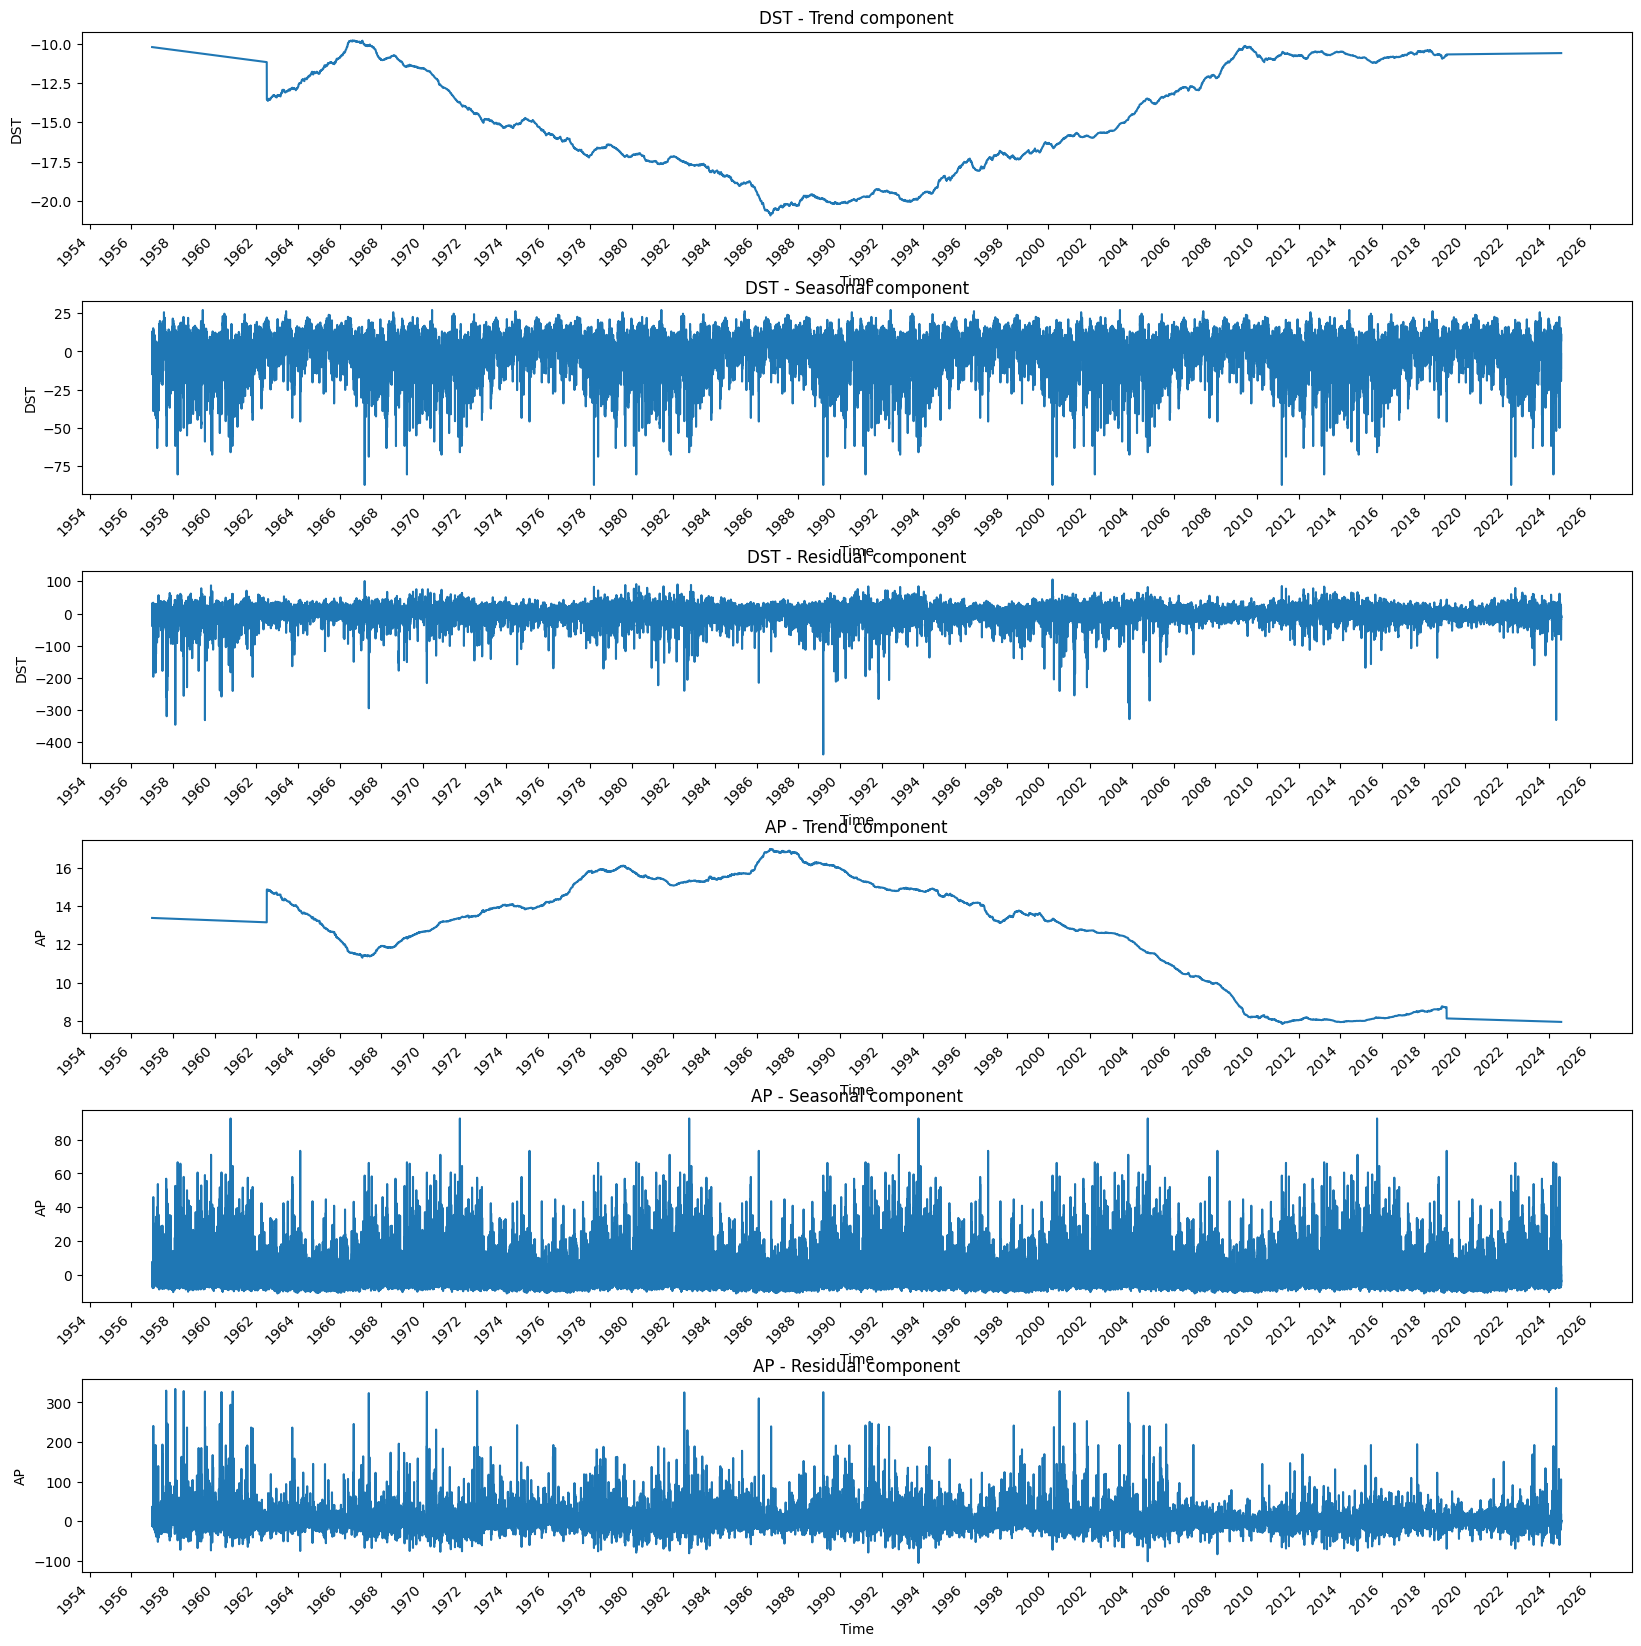

In [64]:
columns = ['DST', 'AP']
components = ['Trend', 'Seasonal', 'Residual']

fig, ax = plt.subplots(6, 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

i = 0

for column in columns:
    for component in components:        
        ax[i].plot(df_raw.Datetime, df_raw[column + f"_{component}"])
        
        ax[i].set_title(f'{column} - {component} component')
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel(column)
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks
        
        ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")
        
        i += 1
      
plt.show()

In [65]:
df_raw = pd.DataFrame({
    'Datetime': df_raw.Datetime,
    'DST_Trend': tsa_dst.trend,
    'DST_Seasonal': tsa_dst.seasonal,
    'DST_Residual': tsa_dst.resid,
    'AP_Trend': tsa_ap.trend,
    'AP_Seasonal': tsa_ap.seasonal,
    'AP_Residual': tsa_ap.resid
}
)
df_raw

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377401,-5.197962,-5.179438
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097113,13.377386,4.516296,4.106317
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140035,13.377372,6.230585,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949210,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180695,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949177,-4.500100,2.550924


In [66]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 10.55 MB  
Final memory usage  : 6.03 MB    (-42.9%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


In [67]:
save_object(df, config.df_save_path)
save_object(preproc_pipe, config.preproc_pipe_save_path)

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/geodstap_tsr.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_geodstap_tsr.pkl
